# Email Spam Detection
<!--
*** I'm using markdown "reference style" links for readability.
*** Reference links are enclosed in brackets [ ] instead of parentheses ( ).
*** See the bottom of this document for the declaration of the reference variables
*** This documentation will be finished when this projects finishes.
-->
1. #### Importing libraries
        this are necessary libraries
            - pandas
            - numpy
            - scikit-learn.preprocessing (LabelEncoder)

In [10]:
import gensim
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import matplotlib.pylab as plt
import nltk
import seaborn as sns

from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
import string
from nltk import pos_tag

from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.linear_model import LogisticRegression
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt_tab')

ValueError: numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject

2. #### Collection of Data
        I use public datasets:
            - Email-Spam-Classification-dataset-csv
            - Enron Email Dataset
            - deceptive-opinion-spam-corpus
            - spam-or-not-spam-dataset
            - spam-email
            - sms-spam-collection-dataset
            - email-spam-dataset
            - email-spam-classification-dataset-csv
        format: Each row is in text (message/email) and label (spam/ham).

In [ ]:
complete_spam = pd.read_csv("/content/completeSpamAssassin.csv", index_col=0)
null_rows = complete_spam[complete_spam.isnull().any(axis=1)]
complete_spam = complete_spam.dropna()
complete_spam.rename(columns={"Body": "message", "Label":'label'}, inplace=True)
complete_spam.head()

,message,label
0,\nSave up to 70% on Life Insurance.\nWhy Spend...,1
1,1) Fight The Risk of Cancer!\nhttp://www.adcli...,1
2,1) Fight The Risk of Cancer!\nhttp://www.adcli...,1
3,##############################################...,1
4,I thought you might like these:\n1) Slim Down ...,1


In [ ]:
enron = pd.read_csv("/content/enronSpamSubset.csv", index_col=0)
enron = enron.drop(columns=["Unnamed: 0"])
enron.rename(columns={"Body": "message", "Label":'label'}, inplace=True)
enron.head()

,message,label
2469,Subject: stock promo mover : cwtd\n * * * urge...,1
5063,Subject: are you listed in major search engine...,1
12564,"Subject: important information thu , 30 jun 20...",1
2796,Subject: = ? utf - 8 ? q ? bask your life with...,1
1468,"Subject: "" bidstogo "" is places to go , things...",1


In [ ]:
ling_spam = pd.read_csv("/content/lingSpam.csv", index_col=0)
ling_spam.rename(columns={"Body": "message", "Label":'label'}, inplace=True)
ling_spam.head()

,message,label
0,Subject: great part-time or summer job !\n \n ...,1
1,Subject: auto insurance rates too high ?\n \n ...,1
2,Subject: do want the best and economical hunti...,1
3,Subject: email 57 million people for $ 99\n \n...,1
4,Subject: do n't miss these !\n \n attention ! ...,1


In [ ]:
deceptive = pd.read_csv("/content/deceptive-opinion.csv")
deceptive = deceptive.iloc[:, [2, 4]]
label = pd.get_dummies(deceptive['polarity'], drop_first=True)
deceptive.drop(columns=['polarity'], inplace=True)
new_deceptive = pd.concat([deceptive, label], axis=1)
new_deceptive.rename(columns={"text": "message", "positive":'label'}, inplace=True)
new_deceptive.head()

,message,label
0,We stayed for a one night getaway with family ...,True
1,Triple A rate with upgrade to view room was le...,True
2,This comes a little late as I'm finally catchi...,True
3,The Omni Chicago really delivers on all fronts...,True
4,I asked for a high floor away from the elevato...,True


In [ ]:
spam = pd.read_csv("/content/spam_or_not_spam.csv")
spam.rename(columns={'email': 'message'}, inplace=True)
spam.head()

,message,label
0,date wed NUMBER aug NUMBER NUMBER NUMBER NUMB...,0
1,martin a posted tassos papadopoulos the greek ...,0
2,man threatens explosion in moscow thursday aug...,0
3,klez the virus that won t die already the most...,0
4,in adding cream to spaghetti carbonara which ...,0


##### Shape of Dataset

In [ ]:
print(f"dataset 1 : {complete_spam.shape}")
print(f"dataset 2 : {spam.shape}")
print(f"dataset 3 : {new_deceptive.shape}")
print(f"dataset 4 : {ling_spam.shape}")
print(f"dataset 5 : {enron.shape}")
print(f"total expected shape : ({complete_spam.shape[0] + spam.shape[0] + new_deceptive.shape[0] + ling_spam.shape[0] + enron.shape[0]}, 2)")

dataset 1 : (6045, 2)
dataset 2 : (3000, 2)
dataset 3 : (1600, 2)
dataset 4 : (2605, 2)
dataset 5 : (10000, 2)
total expected shape : (23250, 2)


In [ ]:
dfs = [complete_spam, spam, new_deceptive, ling_spam, enron]
spam_dataset = pd.concat(dfs, axis=0, ignore_index=True)
spam_dataset.tail()
print(spam_dataset.shape)

(23250, 2)


##### Checking Missing Values

In [ ]:
spam_dataset.isnull().sum()

,0
message,1
label,0


##### Checking Duplicate Values

In [ ]:
spam_dataset.duplicated().sum()

1210

##### Remove Duplicate Values

In [ ]:
spam_dataset = spam_dataset.dropna()
spam_dataset = spam_dataset.drop_duplicates(keep='first')
spam_dataset.head()

,message,label
0,\nSave up to 70% on Life Insurance.\nWhy Spend...,1
1,1) Fight The Risk of Cancer!\nhttp://www.adcli...,1
2,1) Fight The Risk of Cancer!\nhttp://www.adcli...,1
3,##############################################...,1
4,I thought you might like these:\n1) Slim Down ...,1


##### Final Shape of Dataset

In [ ]:
print(f"After removing duplicate values. The final shape of dataset : {spam_dataset.shape}")

After removing duplicate values. The final shape of dataset : (22039, 2)


3. #### EDA aka Exploratory Data Analysis
        The goal is to investigating data, understanding patterns, checking (anomalies, outliers), summarize key structure before applying any types of machine learning or statistical models.


In [ ]:
values = spam_dataset['label'].value_counts()
total = values[0] + values[1]

percentage_0 = (values[0] / total) * 100
percentage_1 = (values[1] / total) * 100

print(f"Percentage of target (ham) : {percentage_0}")
print(f"Percentage of target (spam) : {percentage_1}")

Percentage of target (ham) : 64.6626434956214
Percentage of target (spam) : 35.337356504378604


#### Pie Chart (Email Classification)

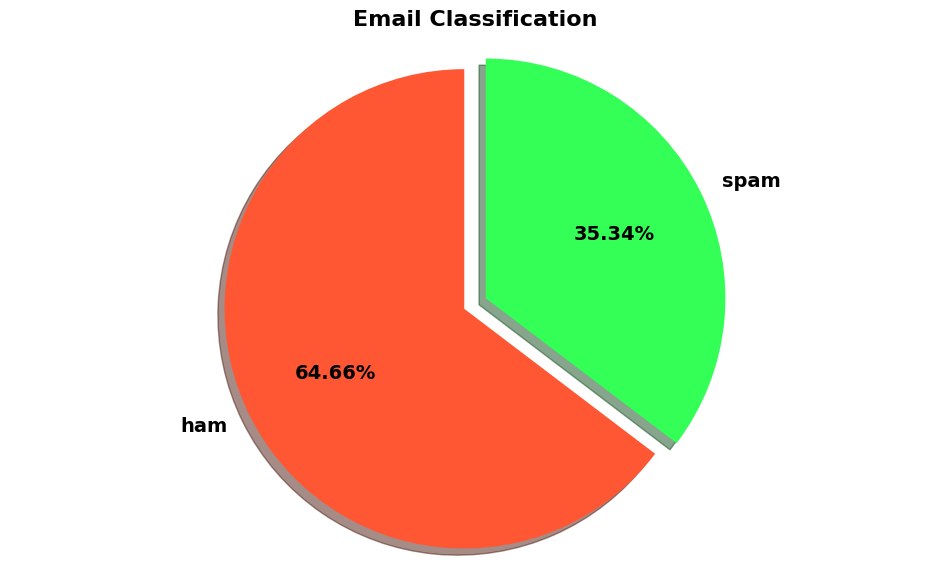

In [ ]:
plt.figure(figsize=(12, 7)) # i know i 'm taking huge figure but i like that

colors = ['#FF5733', '#33FF57'] # red-oraney and green are my colors
myexplode = [0, 0.1]    # define explode parameter to create a gap between slices by 10%
mylabels = ['ham', 'spam']  # ham and spam are categories


plt.pie(
    values,
    startangle=90,  # set angle
    autopct='%0.2f%%',  # add percentage value
    labels=mylabels, # labeling pie with ham and spam
    explode=myexplode, # explode ham with 10%
    colors=colors,  # add your colors
    shadow=True, # add shadow
    textprops={'fontsize': 14, 'fontweight': 'bold'}    # add fontsize and weight
    )

plt.axis('equal')   #set axis equal so that pie looks circle
plt.title("Email Classification", fontweight="bold", fontsize=16)
plt.show()

#### Summary for Text, Chars, Sentences Length

In [ ]:
import re
def count_characters(text):
    words = re.findall(r'[a-zA-Z]', text)
    icount = 0
    for w in words:
        if w.isdigit():
            continue
        icount = icount + 1
    return icount

In [ ]:
spam_dataset['num_characters'] = spam_dataset['message'].apply(count_characters)
spam_dataset['num_words'] = spam_dataset['message'].apply(lambda x: len(nltk.word_tokenize(x)))
spam_dataset['num_sentences'] = spam_dataset['message'].apply(lambda x: len(nltk.sent_tokenize(x)))

spam_dataset[['num_characters', 'num_words', 'num_sentences']].describe()

,num_characters,num_words,num_sentences
count,2.203900e+04,2.203900e+04,22039.000000
mean,1.823136e+03,5.119527e+02,27.475430
std,8.046392e+04,2.441711e+04,1504.483484
min,0.000000e+00,0.000000e+00,0.000000
25%,3.170000e+02,8.800000e+01,3.000000
50%,6.200000e+02,1.740000e+02,8.000000
75%,1.244000e+03,3.480000e+02,16.000000
max,1.193657e+07,3.623500e+06,223247.000000


##### Summary Statistics for the legitimate message (emails)

In [ ]:
spam_dataset[spam_dataset['label'] == 0 ][['num_characters', 'num_sentences', 'num_words']].describe()

,num_characters,num_sentences,num_words
count,1.425100e+04,14251.000000,1.425100e+04
mean,2.164088e+03,32.329872,6.163865e+02
std,1.000321e+05,1870.577373,3.036105e+04
min,3.000000e+00,1.000000,1.000000e+00
25%,3.310000e+02,3.000000,9.200000e+01
50%,6.770000e+02,7.000000,1.890000e+02
75%,1.312000e+03,15.000000,3.700000e+02
max,1.193657e+07,223247.000000,3.623500e+06


##### Summary Statistics for the spam messages (email)

In [ ]:
spam_dataset[spam_dataset['label'] == 1][['num_characters', 'num_sentences', 'num_words']].describe()

,num_characters,num_sentences,num_words
count,7788.000000,7788.000000,7788.000000
mean,1199.238701,18.592450,320.852851
std,3354.267335,50.441562,615.707086
min,0.000000,0.000000,0.000000
25%,298.000000,5.000000,84.000000
50%,533.000000,9.000000,150.000000
75%,1084.000000,18.000000,300.000000
max,195468.000000,3093.000000,13292.000000


In [ ]:
spam_dataset[['label', 'num_characters', 'num_sentences', 'num_words']].corr()

,label,num_characters,num_sentences,num_words
label,1.000000,-0.005732,-0.004365,-0.005786
num_characters,-0.005732,1.000000,0.999390,0.999802
num_sentences,-0.004365,0.999390,1.000000,0.999733
num_words,-0.005786,0.999802,0.999733,1.000000


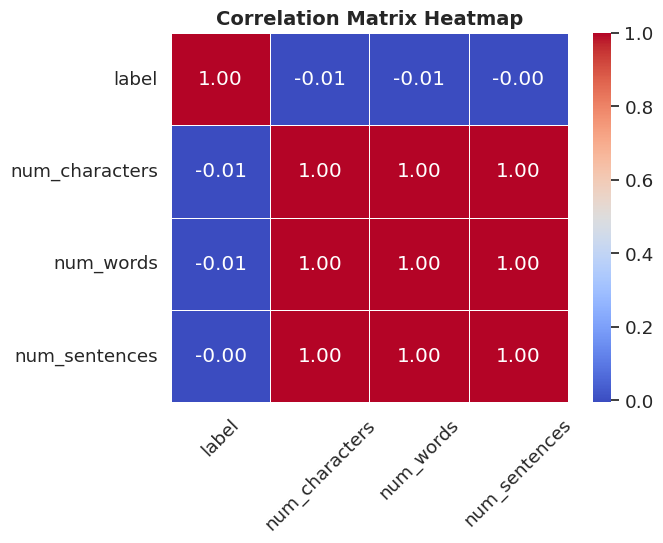

In [ ]:
corr_matrix = spam_dataset[['label', 'num_characters', 'num_words', 'num_sentences']].corr()

sns.set(font_scale=1.2)
sns.heatmap(corr_matrix, annot=True, fmt='0.2f', linewidths=0.5, cmap='coolwarm')

plt.title('Correlation Matrix Heatmap', fontsize=14, fontweight='bold')

plt.xticks(rotation=45)
plt.show()

#### Data Text Preprocessing
        Before data preprocessing let's understand how the spam are introduce in the mail and what type of the spam can be added in the email.

In [ ]:
def custom_tokenizer(text):

    tokens = []

    # replace URLs with tokens
    url_pattern = r'(?:https?\s?:\/\/?|http\s?:\/\/?|https\s?\/\/|http\s?\/\/|www\.)[^\s<>"{}|\\^`\[\]]+'
    urls = re.findall(url_pattern, text)
    text = re.sub(url_pattern, ' URL_TOKEN ', text)
    tokens.extend(['URL_TOKEN'] * len(urls))  # if more than two url then

    # Replace emails with tokens
    email_pattern = r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b'
    emails = re.findall(email_pattern, text)
    text = re.sub(email_pattern, ' EMAIL_TOKEN ', text)
    tokens.extend(['EMAIL_TOKEN'] * len(emails))

    # replace phone numbers
    phone_pattern = r'\b\d{3}[-.]?\d{3}[-.]?\d{4}\b'
    phones = re.findall(phone_pattern, text)
    text = re.sub(phone_pattern, ' PHONE_TOKEN ', text)
    tokens.extend(['PHONE_TOKEN'] * len(phones))

    # replace currency
    currency_pattern =  r'\$\d+(?:\.\d{2})?'
    currency = re.findall(currency_pattern, text)
    text = re.sub(currency_pattern, ' MONEY_TOKEN ', text)
    tokens.extend(['MONEY_TOKEN'] * len(currency))

    # replace numbers
    number_pattern = r'\b\d+(?:\.\d+)?\b'
    numbers = re.findall(number_pattern, text)
    text = re.sub(number_pattern, ' NUM_TOKEN ', text)
    tokens.extend(['NUM_TOKEN'] * len(numbers))

    # remove _____ spaces
    text = re.sub(r'[_]{3,}', ' ', text)

    # tokenizing common words
    word_pattern = r'\b[A-Za-z]+\b'
    words = re.findall(word_pattern, text.lower())
    tokens.extend(words)

    return text, tokens

text = """Visit https://example.com for more info
        Contact us at support@company.com or call 555-0123
        The price is $29.99 for 10 items
        Check out www.github.com and email me at user@domain.org
        Regular text without special patterns"""

text, tokens = custom_tokenizer(text)
print(tokens)
print(text)

['URL_TOKEN', 'URL_TOKEN', 'EMAIL_TOKEN', 'EMAIL_TOKEN', 'MONEY_TOKEN', 'NUM_TOKEN', 'NUM_TOKEN', 'NUM_TOKEN', 'visit', 'for', 'more', 'info', 'contact', 'us', 'at', 'or', 'call', 'the', 'price', 'is', 'for', 'items', 'check', 'out', 'and', 'email', 'me', 'at', 'regular', 'text', 'without', 'special', 'patterns']
Visit  URL_TOKEN  for more info
        Contact us at  EMAIL_TOKEN  or call  NUM_TOKEN - NUM_TOKEN 
        The price is  MONEY_TOKEN  for  NUM_TOKEN  items
        Check out  URL_TOKEN  and email me at  EMAIL_TOKEN 
        Regular text without special patterns


In [ ]:
def text_representation(text):

    # tokenize the word
    tokens = word_tokenize(text)

    tfidf = TfidfVectorizer()
    tfidf_matrix = tfidf.fit_transform(tokens)
    feature_names = tfidf.get_feature_names_out()

    print("TF IDF Vectorizer: ")
    print(f"matrix : {tfidf_matrix}")
    print(f"features : {feature_names}")

text_representation(text)

TF IDF Vectorizer: 
matrix :   (0, 25)	1.0
  (1, 23)	1.0
  (2, 7)	1.0
  (3, 13)	1.0
  (4, 8)	1.0
  (5, 4)	1.0
  (6, 24)	1.0
  (7, 1)	1.0
  (8, 6)	1.0
  (9, 15)	1.0
  (10, 2)	1.0
  (11, 14)	1.0
  (13, 14)	1.0
  (14, 22)	1.0
  (15, 18)	1.0
  (16, 9)	1.0
  (17, 12)	1.0
  (18, 7)	1.0
  (19, 14)	1.0
  (20, 10)	1.0
  (21, 3)	1.0
  (22, 16)	1.0
  (23, 23)	1.0
  (24, 0)	1.0
  (25, 5)	1.0
  (26, 11)	1.0
  (27, 1)	1.0
  (28, 6)	1.0
  (29, 19)	1.0
  (30, 21)	1.0
  (31, 26)	1.0
  (32, 20)	1.0
  (33, 17)	1.0
features : ['and' 'at' 'call' 'check' 'contact' 'email' 'email_token' 'for' 'info'
 'is' 'items' 'me' 'money_token' 'more' 'num_token' 'or' 'out' 'patterns'
 'price' 'regular' 'special' 'text' 'the' 'url_token' 'us' 'visit'
 'without']


In [ ]:
import re
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag, word_tokenize
from nltk.corpus import wordnet

def get_wordnet_pos(tag):
    """Map POS tag to WordNet POS tag for better lemmatization"""
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN  # default to noun

def text_preprocessing(text):
    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words('english'))

    # lowercase
    text = text.lower().strip()

    # clean weird punctuation (like ... or ----)
    text = re.sub(r'\.{2,}', '.', text)
    text = re.sub(r'-{2,}', ' ', text)

    # tokenize
    words = word_tokenize(text)

    # remove punctuation & empty tokens
    words = [w for w in words if w not in string.punctuation and w.strip() != '']

    # POS tagging
    tokens = pos_tag(words)

    # keep important words even if in stopwords
    words_shouldnot_removed = {
        'is','am','are','was','were','be','been','being',
        'have','has','had','having',
        'do','does','did','doing',
        'will','would','can','could','should','shall','may','might','must',
        'not','no','never','nothing','nobody','nowhere',
        'i','you','he','she','it','we','they','me','him','her','us','them',
        'my','your','his','her','its','our','their',
        'this','that','these','those',
        'who','what','when','where','why','how','which',
        'and','or','but','because','if','when','while','although','though',
        'very','really','quite','rather','too','so','such'
    }

    content_pos_tags = {'NN','NNS','NNP','NNPS','JJ','JJR','JJS','VB','VBD','VBG','VBN','VBP','VBZ'}

    lemmatized_sentence = []
    for word, pos in tokens:
        wn_pos = get_wordnet_pos(pos)  # better lemmatization
        lemma = lemmatizer.lemmatize(word, wn_pos)

        if (word in words_shouldnot_removed
            or pos in content_pos_tags
            or word not in stop_words):
            lemmatized_sentence.append(lemma)

    lemm_sent = ' '.join(lemmatized_sentence)

    # final pass with custom tokenizer
    text, tokens = custom_tokenizer(lemm_sent)

    return text

text = """
Subject: 🎉 CONGRATULATIONS! You've Won $1,000,000! 🎉
From: winner-notification@lottery-international.biz
Body:
DEAR LUCKY WINNER!!!
CONGRATULATIONS! You have been selected as the GRAND PRIZE WINNER of our International Email Lottery! Your email address was randomly selected from millions of addresses worldwide.
YOU HAVE WON: $1,000,000 USD!!!
To claim your prize, you MUST respond within 24 HOURS with the following information:

Full Name
Address
Phone Number
Bank Account Details
Copy of ID/Passport

URGENT: Send processing fee of $500 via Western Union to claim your winnings immediately!
Contact our claims agent: Mr. Johnson Smith
Email: claims.agent.smith@totally-legit-lottery.com
Phone: +234-555-7845
This offer expires TOMORROW! Don't miss this once-in-a-lifetime opportunity!
Best Regards,
International Lottery Commission
"""
processed_tokens = text_preprocessing(text)
print(processed_tokens)

subject 🎉 congratulation you 've win  NUM_TOKEN , NUM_TOKEN , NUM_TOKEN  🎉 winner-notification lottery-international.biz body dear lucky winner congratulation you have be select grand prize winner our international email lottery your email address be randomly select million address worldwide you have win  NUM_TOKEN , NUM_TOKEN , NUM_TOKEN  usd claim your prize you must respond within  NUM_TOKEN  hour follow information full name address phone number bank account detail copy id/passport urgent send process fee  NUM_TOKEN  via western union claim your winning immediately contact our claim agent mr. johnson smith email claims.agent.smith totally-legit-lottery.com phone + PHONE_TOKEN  this offer expire tomorrow do n't miss this once-in-a-lifetime opportunity best regard international lottery commission


In [ ]:
spam_dataset['cleaned_message'] = spam_dataset['message'].apply(text_preprocessing)
spam_dataset.head()

,message,label,num_characters,num_words,num_sentences,cleaned_message
0,\nSave up to 70% on Life Insurance.\nWhy Spend...,1,775,191,12,save NUM_TOKEN life insurance why spend more...
1,1) Fight The Risk of Cancer!\nhttp://www.adcli...,1,526,139,5,NUM_TOKEN fight risk cancer URL_TOKEN o= N...
2,1) Fight The Risk of Cancer!\nhttp://www.adcli...,1,416,113,4,NUM_TOKEN fight risk cancer URL_TOKEN o= N...
3,##############################################...,1,1753,690,35,adult club offer free membership instant acces...
4,I thought you might like these:\n1) Slim Down ...,1,463,108,4,i think you might like these NUM_TOKEN slim ...


In [ ]:
# calculating the length of the cleaned message
spam_dataset['cleaned_message'].apply(lambda x: len(x.split(" ")))

,cleaned_message
0,142
1,111
2,95
3,378
4,84
...,...
23245,34
23246,1557
23247,195
23248,51


In [ ]:
print(f"length of the cleaned preprocessed message : {len(spam_dataset['cleaned_message'])}")

length of the cleaned preprocessed message : 22039


#### Tokenization

In [ ]:
tokenized_docs = [word_tokenize(doc) for doc in spam_dataset['cleaned_message']]
tokenized_docs[:10]

[['save',
  'NUM_TOKEN',
  'life',
  'insurance',
  'why',
  'spend',
  'more',
  'you',
  'have',
  'life',
  'quote',
  'saving',
  'ensure',
  'your',
  'family',
  "'s",
  'financial',
  'security',
  'be',
  'very',
  'important',
  'life',
  'quote',
  'saving',
  'make',
  'buy',
  'life',
  'insurance',
  'simple',
  'and',
  'affordable',
  'we',
  'provide',
  'free',
  'access',
  'very',
  'best',
  'company',
  'and',
  'low',
  'rates.life',
  'quote',
  'saving',
  'be',
  'fast',
  'easy',
  'and',
  'save',
  'you',
  'money',
  'let',
  'u',
  'help',
  'you',
  'get',
  'start',
  'best',
  'value',
  'country',
  'new',
  'coverage',
  'you',
  'can',
  'save',
  'hundred',
  'or',
  'even',
  'thousand',
  'dollar',
  'request',
  'free',
  'quote',
  'lifequote',
  'saving',
  'our',
  'service',
  'will',
  'take',
  'you',
  'less',
  'NUM_TOKEN',
  'minute',
  'complete',
  'shop',
  'and',
  'compare',
  'save',
  'NUM_TOKEN',
  'type',
  'life',
  'insurance'

In [ ]:
print(f"length of the tokenized documents : {len(tokenized_docs)}")

length of the tokenized documents : 22039


#### Creating Doc2Vec Document embeddings

In [ ]:
tagged_data = [TaggedDocument(words=doc, tags=[str(i)]) for i, doc in enumerate(tokenized_docs)]
tagged_data[:10]


[TaggedDocument(words=['save', 'NUM_TOKEN', 'life', 'insurance', 'why', 'spend', 'more', 'you', 'have', 'life', 'quote', 'saving', 'ensure', 'your', 'family', "'s", 'financial', 'security', 'be', 'very', 'important', 'life', 'quote', 'saving', 'make', 'buy', 'life', 'insurance', 'simple', 'and', 'affordable', 'we', 'provide', 'free', 'access', 'very', 'best', 'company', 'and', 'low', 'rates.life', 'quote', 'saving', 'be', 'fast', 'easy', 'and', 'save', 'you', 'money', 'let', 'u', 'help', 'you', 'get', 'start', 'best', 'value', 'country', 'new', 'coverage', 'you', 'can', 'save', 'hundred', 'or', 'even', 'thousand', 'dollar', 'request', 'free', 'quote', 'lifequote', 'saving', 'our', 'service', 'will', 'take', 'you', 'less', 'NUM_TOKEN', 'minute', 'complete', 'shop', 'and', 'compare', 'save', 'NUM_TOKEN', 'type', 'life', 'insurance', 'click', 'your', 'free', 'quote', 'protect', 'your', 'family', 'be', 'best', 'investment', 'you', "'ll", 'ever', 'make', 'if', 'you', 'be', 'receipt', 'this'

In [ ]:
print(f"length of the tagged documents : {len(tagged_data)}")

length of the tagged documents : 22039


In [37]:
# training the doc2vec model.
model = Doc2Vec(vector_size=30, min_count=2, epochs=30)
model.build_vocab(tagged_data)
model.train(tagged_data, total_examples=model.corpus_count, epochs=model.epochs)

In [38]:
# get the vectors for the document.
document_vectors = [model.infer_vector(doc) for doc in tokenized_docs]

In [39]:
for i, doc in enumerate(spam_dataset['cleaned_message']):
  print(f" original doc {i+1} : {doc[:100]}")
  print(document_vectors[i])
  print()

Streaming output truncated to the last 5000 lines.
 -0.11898881 -0.21992625 -0.5297697  -0.6529019   0.10903096 -0.1945739
  0.08012363  0.82114774  2.2534966   0.03345573  0.74668133 -0.31768566]

 original doc 21339 : subject re pre meeting weathereffects site cruise vince you re right it be wednesday see you ed orig
[ 0.6463457   1.4681497   5.6489854  -0.39595762  2.521974   -0.49094668
  0.2705682   2.2472928   1.0802981  -3.5865781  -1.0025595   0.21584901
 -1.1361507  -1.1790836  -2.974402    1.2217575  -5.5476184   2.1087482
 -0.8265789   0.30802038 -0.15171732 -2.0042322   0.17981628  3.7281663
  0.29520914  1.4866223   2.2103024   2.2438507  -2.1334426   0.27233604]

 original doc 21340 : subject re meeting request i will ask rebekah try set it monday kg vince j kaminski ect  NUM_TOKEN  
[-0.24306902  0.5744441   1.0427554   0.3488113   0.5318726  -0.14851958
  0.5837062  -0.34043834 -0.1704189   0.5611805   0.7753747  -0.06148549
 -1.425478   -0.18261829 -2.6979299   0.10601

In [41]:
print(f"length of the document embedings : {len(document_vectors)}")
print(f"length of the labeled columns : {len(spam_dataset['label'])}")

length of the document embedings : 22039
length of the labeled columns : 22039


#### Splitting the Dataset into the Training and Testing Set

In [42]:
X_train, X_test, y_train, y_test = train_test_split(document_vectors, spam_dataset['label'], test_size=0.2, random_state=42)

In [44]:
# shapes of the training and test sets
print(f"Shape of the X train set : {len(X_train)}")
print(f"Shape of the X test set: {len(X_test)}")
print(f"Shape of the y train set: {len(y_train)}")
print(f"Shape of the y test set: {len(y_test)}")

Shape of the X train set : 17631
Shape of the X test set: 4408
Shape of the y train set: 17631
Shape of the y test set: 4408


#### Model Training (Lstm)

In [45]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping


In [46]:
max_len = 200
max_words = 1024
# defining the lstm model
def lstm_model():
  inputs = Input(name='inputs', shape=[max_len])
  layer = Embedding(max_words, 128, input_length=max_len)(inputs)
  layer = LSTM(64)(layer)
  layer = Dense(256, name='FC1')(layer)
  layer = Activation('relu')(layer)
  layer = Dropout(0.5)(layer)
  layer = Dense(1, name='out_layer')(layer)
  layer = Activation('sigmoid')(layer)
  model = Model(inputs=inputs, outputs=layer)
  return model

#### Converting Array to Matrix

In [47]:
# Convert text sequences to padded matrix
X_train = pad_sequences(X_train, maxlen=max_len, padding='post', truncating='post')
X_test  = pad_sequences(X_test,  maxlen=max_len, padding='post', truncating='post')

# Ensure they are NumPy arrays
import numpy as np
X_train = np.array(X_train)
X_test  = np.array(X_test)
y_train = np.array(y_train)
y_test  = np.array(y_test)

#### summary and compiling

In [48]:
model = lstm_model()
model.summary()
model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])
model.fit(X_train, y_train, batch_size=128, epochs=10, validation_split=0.2, verbose=1)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ inputs (InputLayer)             │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 200, 128)       │       131,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ FC1 (Dense)                     │ (None, 256)            │        16,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ out_layer (Dense)               │ (None, 1)              │           257 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 197,377 (771.00 KB)

 Trainable params: 197,377 (771.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 55s 469ms/step - accuracy: 0.6347 - loss: 0.6601 - val_accuracy: 0.6569 - val_loss: 0.6457
Epoch 2/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 53s 478ms/step - accuracy: 0.6417 - loss: 0.6536 - val_accuracy: 0.6569 - val_loss: 0.6435
Epoch 3/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 81s 469ms/step - accuracy: 0.6442 - loss: 0.6531 - val_accuracy: 0.6569 - val_loss: 0.6431
Epoch 4/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 82s 475ms/step - accuracy: 0.6407 - loss: 0.6545 - val_accuracy: 0.6569 - val_loss: 0.6434
Epoch 5/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 80s 455ms/step - accuracy: 0.6410 - loss: 0.6541 - val_accuracy: 0.6569 - val_loss: 0.6431
Epoch 6/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 76s 689ms/step - accuracy: 0.6435 - loss: 0.6528 - val_accuracy: 0.6569 - val_loss: 0.6437
Epoch 7/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 86s 729ms/step - accuracy: 0.6352 - loss: 0.6577 - val_accuracy: 0.6569 - val_loss: 0.6431
Epoch 8/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 91s 806ms/step - accuracy: 0.6437 - loss: 0

#### Visualizing Accuracy and Loss

In [49]:
loss, acc = model.evaluate(X_train, y_train)
print(f"loss of Training is {loss:.2f}")
print(f"accuracy of Training is {acc:.2f}")

551/551 ━━━━━━━━━━━━━━━━━━━━ 24s 43ms/step - accuracy: 0.6445 - loss: 0.6510
loss of Training is 0.65
accuracy of Training is 0.65


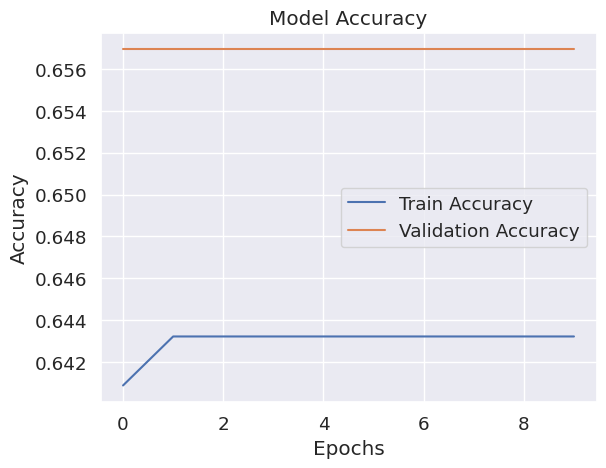

In [51]:
hist = model.history.history
plt.plot(hist['accuracy'], label="Train Accuracy")
plt.plot(hist['val_accuracy'], label='Validation Accuracy')
plt.title("Model Accuracy")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

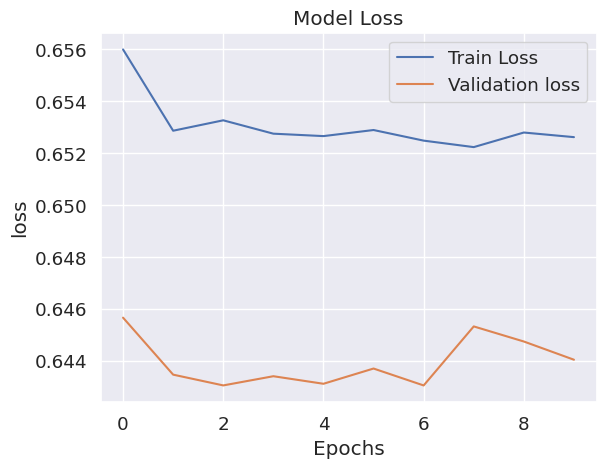

In [52]:
plt.plot(hist['loss'], label="Train Loss")
plt.plot(hist['val_loss'], label='Validation loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [53]:
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)

pd.DataFrame(y_pred[:10], columns=['Prediction'])

138/138 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step


,Prediction
0,0
1,0
2,0
3,0
4,0
5,0
6,0
7,0
8,0
9,0


In [70]:
spam = 0
ham = 0
for i in y_pred:
  if i == 0:
    spam += 1
  else:
    ham += 1
print(f"length of possible prediction spam: {spam}")
print(f"length of possible prediction ham: {ham}")

length of possible prediction spam: 4408
length of possible prediction ham: 0


#### Visualizing Confusion Matrix

In [61]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

In [56]:
cm = confusion_matrix(y_pred, y_test)
print(f"confusion matrix \n {cm}")

confusion matrix 
 [[2862 1546]
 [   0    0]]


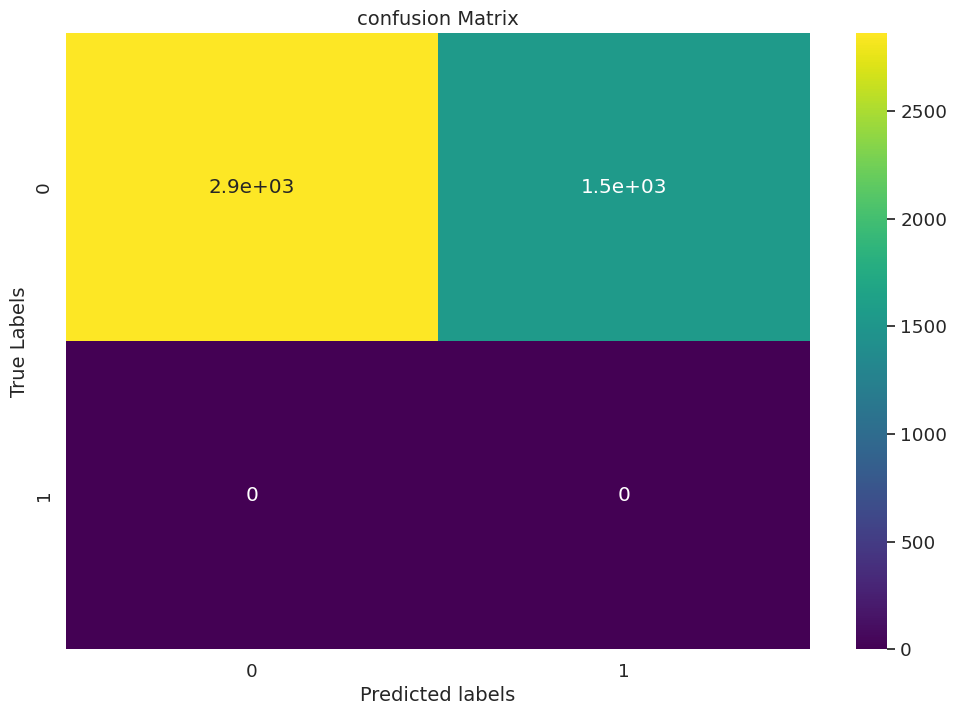

In [59]:
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, cbar=True, cmap="viridis")
plt.title("confusion Matrix", fontsize=14)
plt.xlabel("Predicted labels", fontsize=14)
plt.ylabel('True Labels', fontsize=14)
plt.show()

In [62]:
print("Classification report \n")
print(classification_report(y_pred, y_test))

Classification report 

              precision    recall  f1-score   support

           0       1.00      0.65      0.79      4408
           1       0.00      0.00      0.00         0

    accuracy                           0.65      4408
   macro avg       0.50      0.32      0.39      4408
weighted avg       1.00      0.65      0.79      4408



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


#### Single Prediction

In [66]:
input_text =  X_test[8]
print(f"before expanding dims : {input_text, input_text.shape}")
input_text = np.expand_dims(input_text, axis=0)
print(f"after expanding the col dims : {input_text, input_text.shape}")

# make the prediction
prediction = model.predict(input_text)

if prediction[0][0] > 0.5:
  print("Ham")
else:
  print("Spam")

before expanding dims : (array([ 1, -3, -3, -1,  0,  0,  2,  0, -3, -1,  1,  2, -4, -2, -1,  0,  0,
        0, -1,  3,  3, -4, -2,  0, -1, -1,  1,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0], dtype=int32), (200,))
after expanding the col dims : (array([[ 1, -3, -3, -1,  0,  0,  2, 